# Modelo de clasificación por tipo de espacio

### Importaciones

In [36]:
import numpy as np
import os
import PIL
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

import seaborn as sn
import pandas as pd
from datetime import datetime

### Construcción de dataset

In [37]:
#Preprocesamiento de los datos
directory="E:/TesisMA/Datos/Data4Classes"
#directory1="E:/TesisMA/Datos/DataB"
img_height=512
img_width=512
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))


Found 6774 files belonging to 4 classes.
Using 5420 files for training.
Found 6774 files belonging to 4 classes.
Using 1354 files for validation.


### Analisis del dataset

In [38]:
class_names = train_ds.class_names
print(class_names)
num_classes = 4

['bathroom', 'bedroom', 'kitchen', 'social']


[1230, 1846, 1200, 1144]


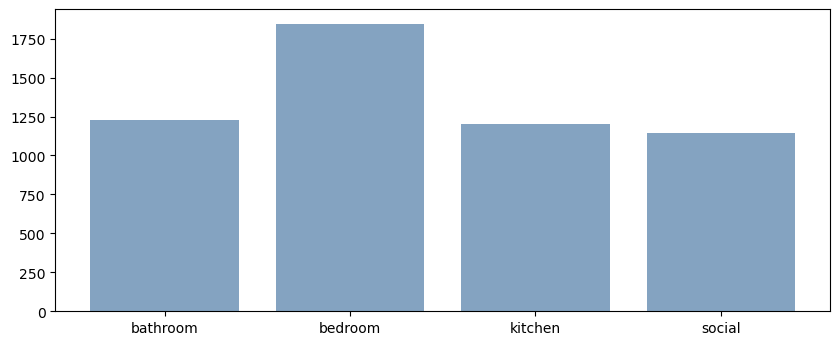

In [5]:
y = np.concatenate([y for x, y in train_ds], axis=0)
labels = list(y)
elements_per_class = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class.append(labels.count(i))
print(elements_per_class)
plt.bar(class_names,elements_per_class,color=(0.2, 0.4, 0.6, 0.6));

1354


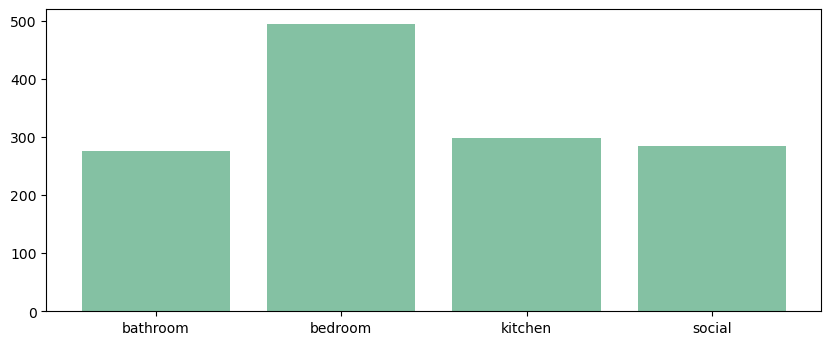

In [6]:
labels1 = np.concatenate([y for x, y in val_ds], axis=0)
labels1 = list(labels1)
elements_per_class1 = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class1.append(labels1.count(i))
print(sum(elements_per_class1))
plt.bar(class_names,elements_per_class1,color=(0.2, 0.6, 0.4, 0.6));

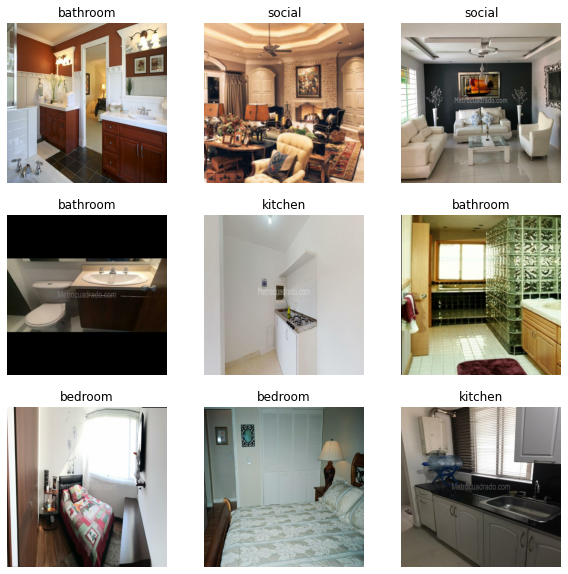

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

### CNN

In [31]:
model = Sequential([
  #Capa para realizar data augmantation
  data_augmentation,
  #Priemera capa entrada de 256x256 x3 canales de color
  layers.experimental.preprocessing.Rescaling(1/255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1), #    Si empiza a haber ploblemas se pone el dropout 
  layers.Flatten(),
  #layers.BatchNormalization(),
  layers.Dense(128,activation="relu", kernel_initializer="he_normal"),
  #layers.Dropout(0.1),
  #layers.LeakyReLU(alpha=0.1),
  #layers.BatchNormalization(),
  layers.Dense(64,activation="relu", kernel_initializer="he_normal"),
  #layers.Dropout(0.1),
  #layers.LeakyReLU(alpha=0.1),
  #layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax')
])

### LRF Finder

In [32]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 64)     

In [34]:
checkpoint_filepath="E:/TesisMA/Modelos/Best_Modelo4_512_4_dropout01_conv_lr0005"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [35]:
epochs=100
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs,
callbacks=[model_checkpoint_callback]
)

Epoch 1/100
170/170 [==============================] - 712s 4s/step - loss: 1.3649 - accuracy: 0.3666 - val_loss: 1.2180 - val_accuracy: 0.4343
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos\Best_Modelo4_512_4_dropout01_conv_lr0005\assets
Epoch 2/100
170/170 [==============================] - 956s 6s/step - loss: 1.2153 - accuracy: 0.4341 - val_loss: 1.2620 - val_accuracy: 0.4047
Epoch 3/100
170/170 [==============================] - 919s 5s/step - loss: 1.1979 - accuracy: 0.4526 - val_loss: 1.2573 - val_accuracy: 0.3959
Epoch 4/100
170/170 [==============================] - 903s 5s/step - loss: 1.1791 - accuracy: 0.4627 - val_loss: 1.1398 - val_accuracy: 0.4934
INFO:tensorflow:Assets written to: E:/TesisMA/Modelos\Best_Modelo4_512_4_dropout01_conv_lr0005\assets
Epoch 5/100
170/170 [==============================] - 733s 4s/step - loss: 1.1425 - accuracy: 0.4959 - val_loss: 1.1371 - val_accuracy: 0.4808
Epoch 6/100
170/170 [==============================] - 738s 4s/step - loss: 

170/170 [==============================] - 733s 4s/step - loss: 0.6551 - accuracy: 0.7408 - val_loss: 0.7600 - val_accuracy: 0.7260
Epoch 47/100
170/170 [==============================] - 737s 4s/step - loss: 0.6316 - accuracy: 0.7577 - val_loss: 0.7543 - val_accuracy: 0.7260
Epoch 48/100
170/170 [==============================] - 744s 4s/step - loss: 0.6250 - accuracy: 0.7557 - val_loss: 0.7022 - val_accuracy: 0.7356
Epoch 49/100
170/170 [==============================] - 738s 4s/step - loss: 0.6353 - accuracy: 0.7598 - val_loss: 0.7437 - val_accuracy: 0.7245
Epoch 50/100
170/170 [==============================] - 739s 4s/step - loss: 0.6175 - accuracy: 0.7596 - val_loss: 0.7599 - val_accuracy: 0.7120
Epoch 51/100
170/170 [==============================] - 730s 4s/step - loss: 0.6201 - accuracy: 0.7624 - val_loss: 0.7405 - val_accuracy: 0.7282
Epoch 52/100
170/170 [==============================] - 736s 4s/step - loss: 0.6175 - accuracy: 0.7581 - val_loss: 0.7495 - val_accuracy: 0.733

170/170 [==============================] - 900s 5s/step - loss: 0.4381 - accuracy: 0.8423 - val_loss: 0.7393 - val_accuracy: 0.7408


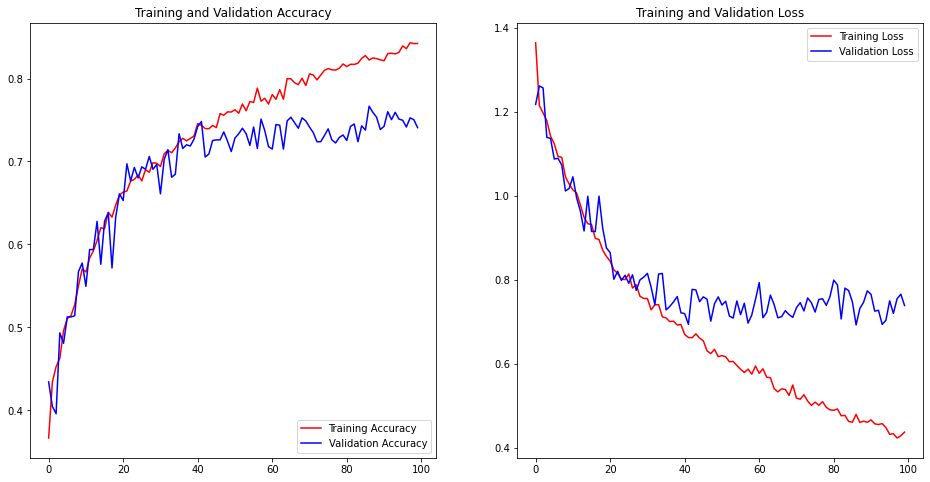

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

sn.set_palette(sn.color_palette("husl", 2))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='blue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Confusion matrix

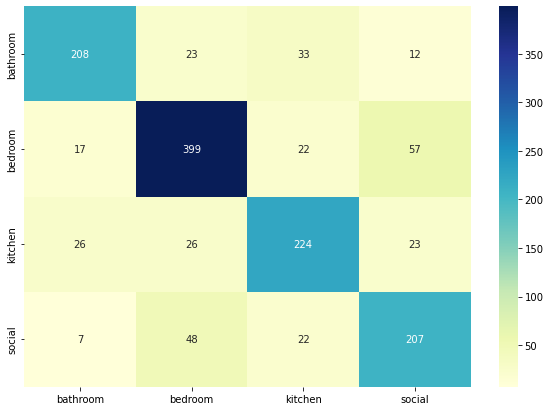

In [40]:
# Cargar mejor modelo 
model = tf.keras.models.load_model(checkpoint_filepath)

predictions = np.array([])
labels = np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])  
  labels= np.concatenate([labels, y])

matriz = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
df_cm = pd.DataFrame(matriz, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",  fmt='g');

In [41]:
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.81, 0.8, 0.74, 0.69]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.75, 0.81, 0.75, 0.73]


In [42]:
report = model.evaluate(val_ds,return_dict=True)
index=["Values"]
table=pd.DataFrame(report,index=index) 
table

43/43 [==============================] - 53s 1s/step - loss: 0.6932 - accuracy: 0.7666


,loss,accuracy
Values,0.693174,0.766617


In [43]:
def metricasCM(matriz):
    # Bien clasificados sobre columna / De todas las X clasificadas solo el %  fue correcto
    metrica1= []
    # Bien clasificados sobre la fila / De todas las que deberías ser clasificadas como X solo el % fue corrcto 
    metrica2= []
    for j in range(0,4):
        suma=0
        for i in range(0,4):
            suma=suma+matriz[i][j]
        metrica1.append((matriz[j][j]/suma).round(2))
        metrica2.append((matriz[j][j]/sum(matriz[j])).round(2))
    print("De todas las X clasificadas solo el %  fue correcto",metrica1)
    print("De todas las que deberían ser clasificadas como X el % fue corrcto ",metrica2)
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.81, 0.8, 0.74, 0.69]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.75, 0.81, 0.75, 0.73]


#### TensorBoard

In [ ]:
root_dir = "E:/TesisMA/Modelos/my_log"
def get_run_dir():
    import time
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%D")
    return os.path.join(root_dir,run_id)

tensorboard_cb = keras.callbacks.TensorBoard(get_run_dir())


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=E:/TesisMA/Modelos/my_log --port 6006